0.00234324 -0.00240229


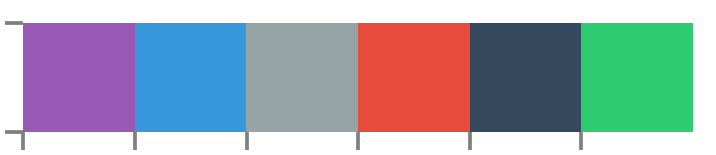

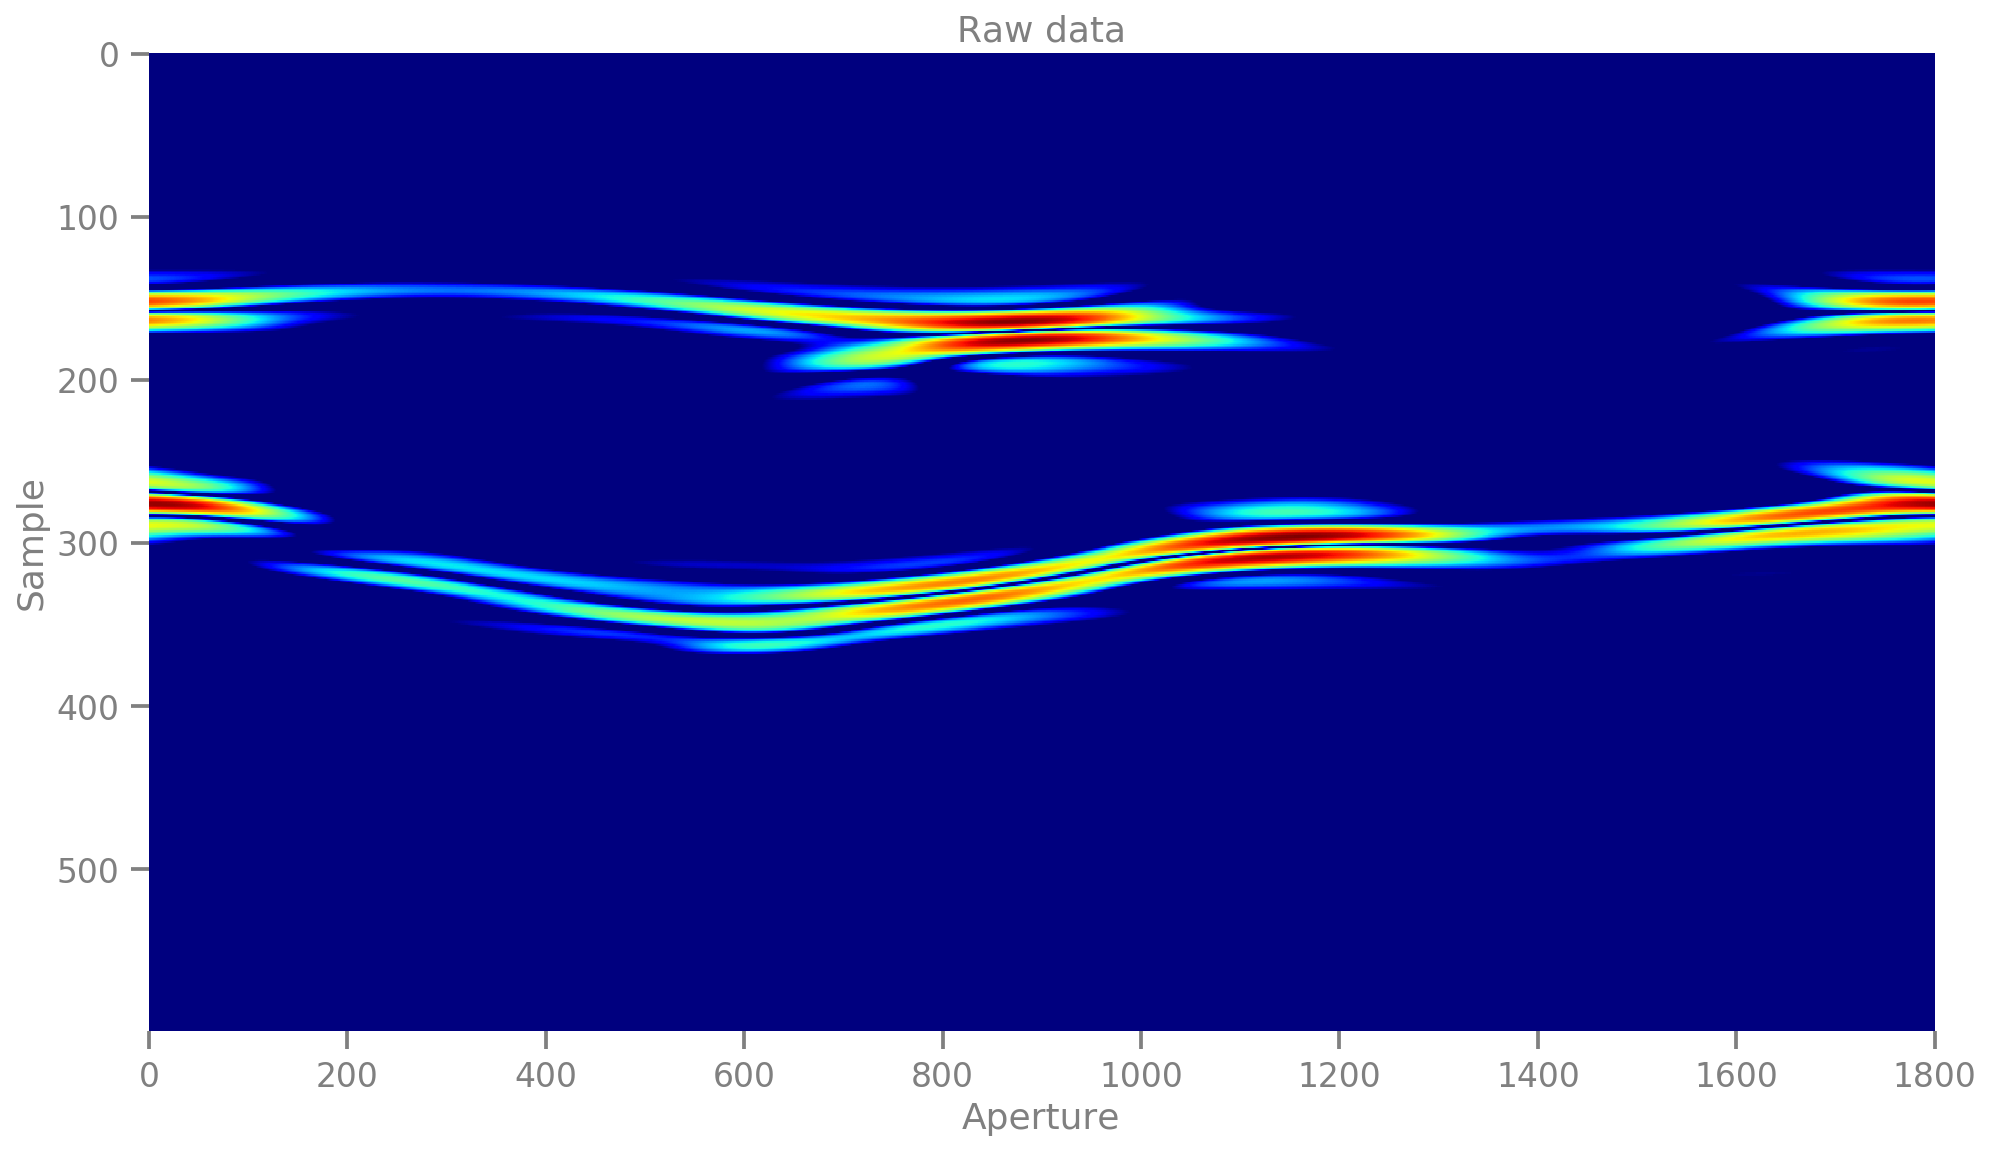

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format="retina"
import scipy.misc
from utils import imsave
import tensorflow as tf
import numpy as np
import time
import sys
import matplotlib as mpl

from sar_utilities import to_dB, visualize_raw_data, get_spectrum, \
    visualize_raw_data_spectrum, insert_freq_gaps, \
    generate_raw_data_from_dict, downsample, snr, \
    add_gaussian_noise, preprocess_train, preprocess_test, \
    generate_raw_data
import scipy.io as sio
from matplotlib.colors import LogNorm, PowerNorm

mpl.rcParams["axes.grid"] = False
mpl.rcParams["grid.color"] = "#f5f5f5"
mpl.rcParams["axes.facecolor"] = "#ededed"
mpl.rcParams["axes.spines.left"] = False
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.bottom"] = False
mpl.rcParams['axes.labelcolor'] = "grey"
mpl.rcParams['xtick.color'] = 'grey'
mpl.rcParams['ytick.color'] = 'grey'
from cycler import cycler
import seaborn as sns
sns.set_context("talk")
color_palette = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.palplot(color_palette)
mpl.rcParams["axes.prop_cycle"] = cycler('color', color_palette)
ori_color = color_palette[1]
corrupted_color = color_palette[0]
reconstructed_color = color_palette[5]

DATA_PATH = "/data/dung/sargan"
import os
float_type = np.float32
mat_file_name = "sar_dict_small"
sar_dict_data = sio.loadmat(os.path.join(DATA_PATH, mat_file_name + ".mat"))
ori_n_apertures = int(sar_dict_data["n_apertures"][0][0])
ori_n_samples = int(sar_dict_data["n_samples"][0][0])
sar_dict_mat = sar_dict_data["sar_dict"].astype(float_type)
transmitted_pulse = sar_dict_data["pulse"].astype(float_type)
transmistted_pulse_sample_period = sar_dict_data["pulse_sampling_period"][0][0].astype(float_type)
sampling_period = transmistted_pulse_sample_period

real_data_filename = "C2"
real_data_file_path = os.path.join(DATA_PATH, "real_sar_data", real_data_filename+".mat")
real_mat_data = sio.loadmat(real_data_file_path)
real_raw_data = real_mat_data["Data"]
real_ori_n_samples, real_ori_n_apertures = real_raw_data.shape
calibrated_real_raw_data = np.vstack((np.zeros((300, real_ori_n_apertures)), real_raw_data, np.zeros((600, real_ori_n_apertures))))
print(np.max(real_raw_data), np.min(real_raw_data))

fig = plt.figure(figsize=(16, 9)); ax = fig.add_subplot(111);
ax = visualize_raw_data(real_raw_data, ax, set_ticks=True)
ax.set_title("Raw data", color="gray")
ax.set_xlabel("Aperture"); ax.set_ylabel("Sample")
raw_data_filepath = os.path.join(DATA_PATH, "figures", "playground", 
                                  real_data_filename+"_raw_data")
plt.savefig(raw_data_filepath, dpi=300)

n_fft = ori_n_samples
sampling_freq = 1. / (sampling_period)
df = sampling_freq / n_fft
freq = [df*i / 1e9 for i in range(0, n_fft)]    

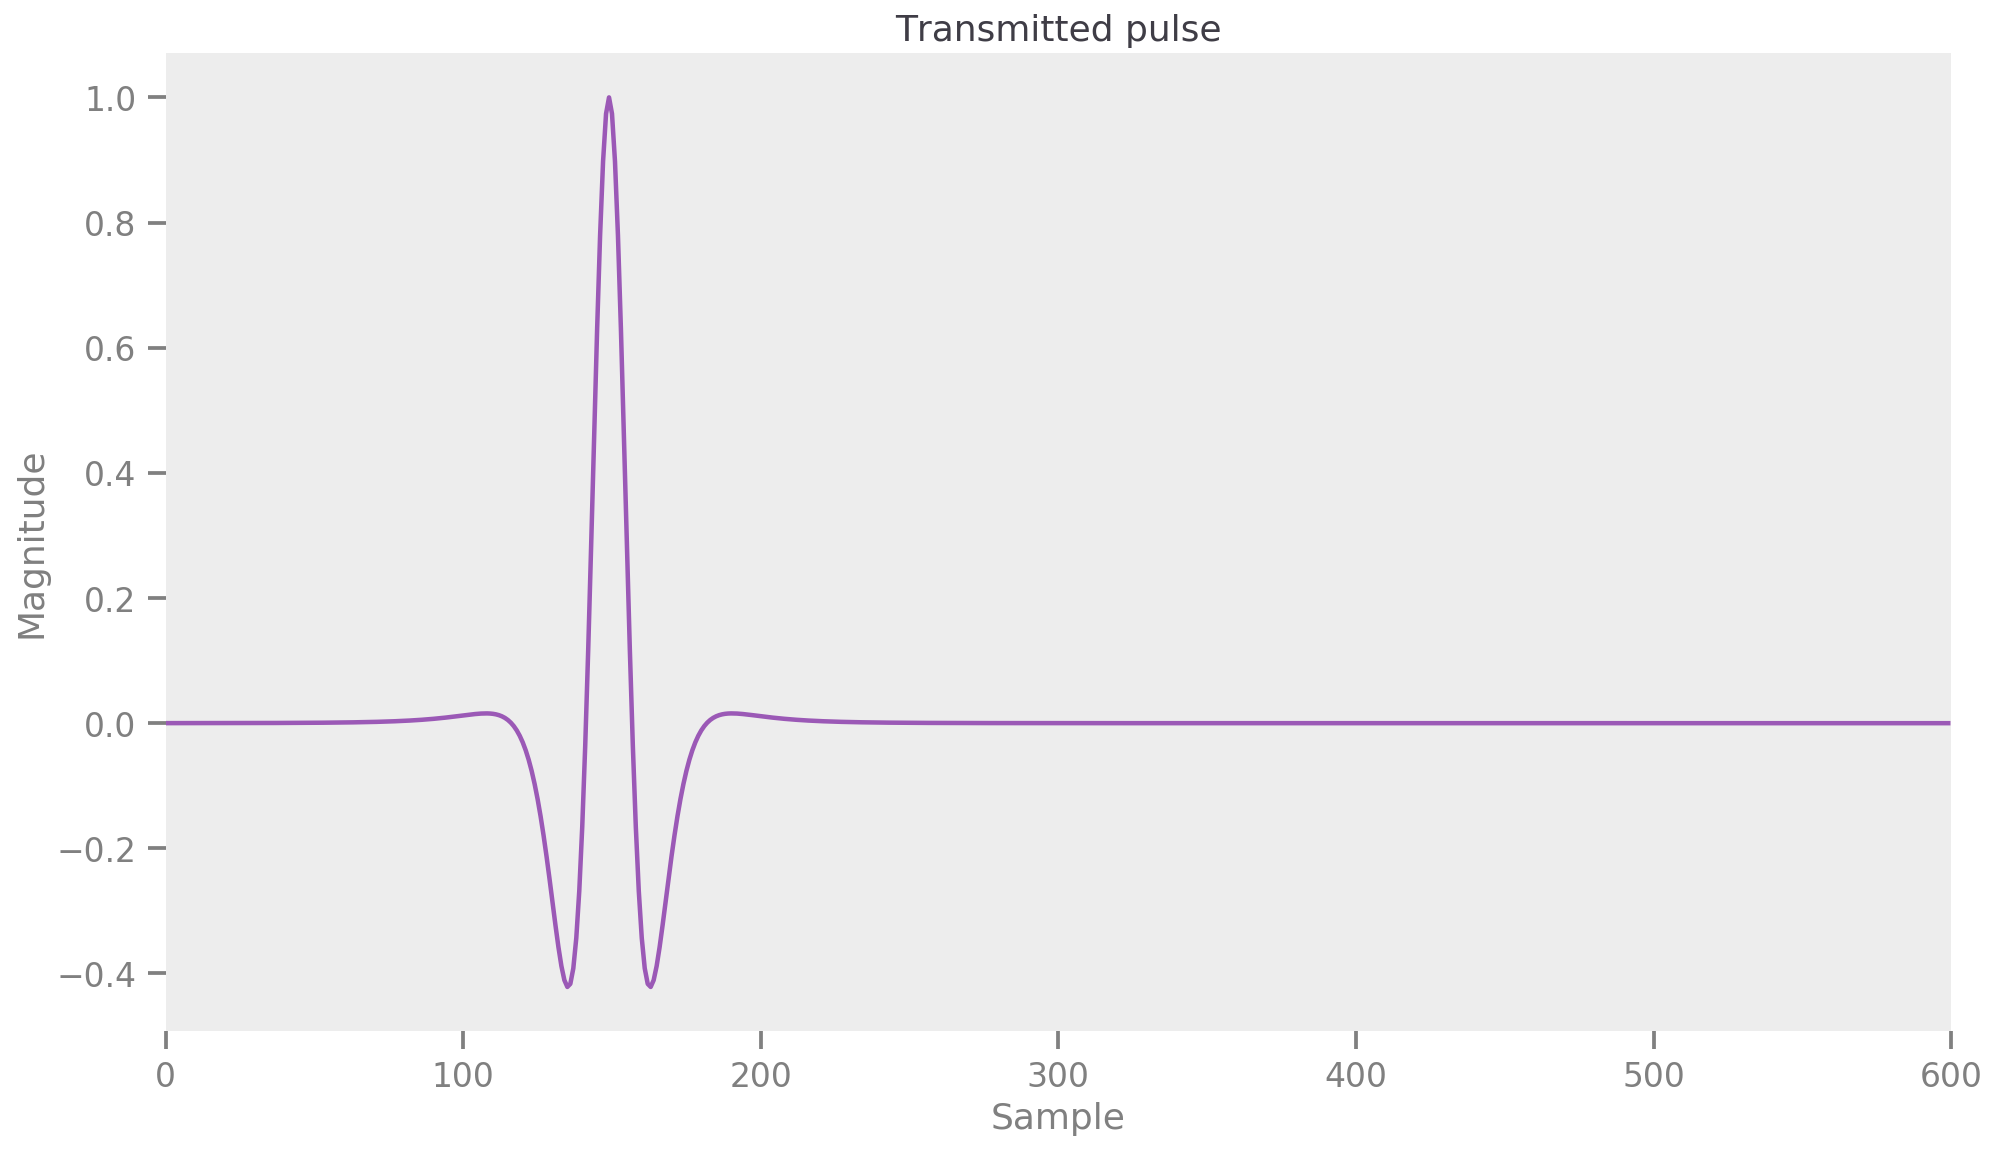

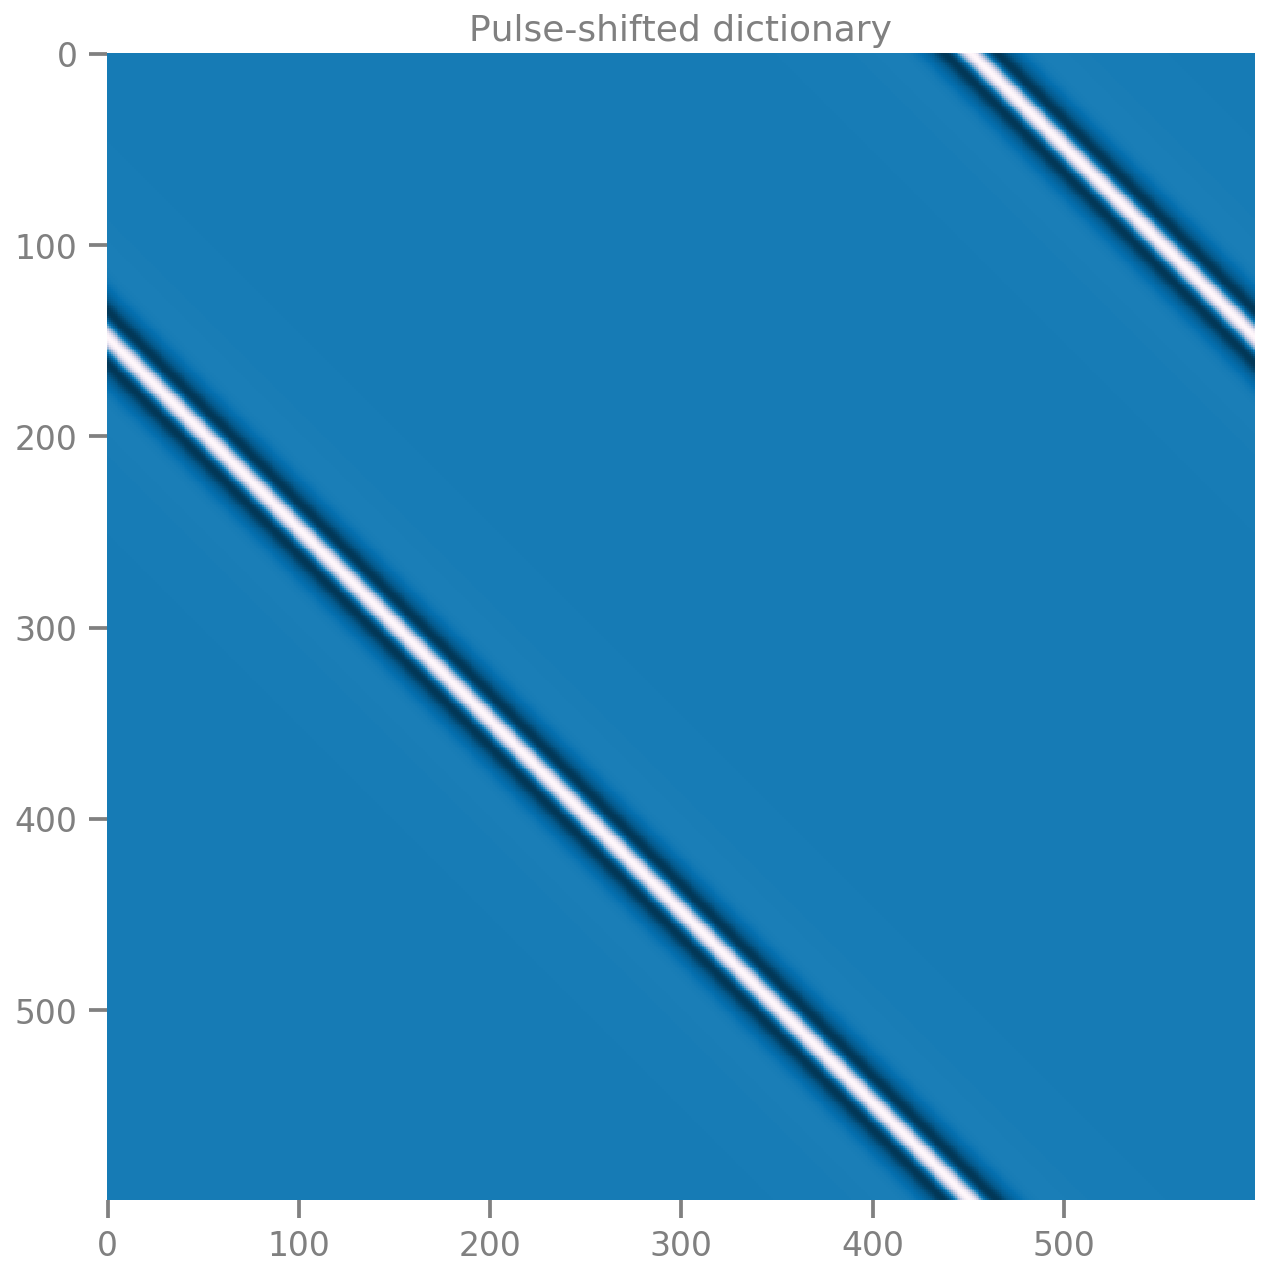

In [18]:
fig = plt.figure(figsize=(16, 9)); ax = fig.add_subplot(111)
ax.plot(transmitted_pulse)
ax.set_title("Transmitted pulse");
ax.set_xlabel("Sample"); ax.set_ylabel("Magnitude")
ax.set_xlim([0, transmitted_pulse.shape[0]])
transmitted_pulse_filepath = os.path.join(DATA_PATH, "figures", "playground",
                                           "transmitted_pulse")
plt.savefig(transmitted_pulse_filepath, dpi=300)

# CONSTRUCT TOEPLITZ DICTIONARY BY SHIFTING THE TRANSMITTED PULSE
from scipy.linalg import circulant
D = circulant(transmitted_pulse)
fig = plt.figure(figsize=(9, 9)); ax = fig.add_subplot(111)
ax.imshow(D, cmap="PuBu_r")
ax.set_title("Pulse-shifted dictionary", color="gray")
plt.tight_layout()
pulse_shifted_dict_filepath = os.path.join(DATA_PATH, "figures", "playground",
                                           "pulse_shifted_dictionary")
plt.savefig(pulse_shifted_dict_filepath, dpi=300)



In [39]:
# Decompose real data
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
n_nonzero_coefs = 100
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
omp.fit(D, real_raw_data)
coef = omp.coef_

/home/dung/anaconda3/envs/tensorflow-gpu-p36/lib/python3.6/site-packages/sklearn/linear_model/omp.py:385: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)


/home/dung/anaconda3/envs/tensorflow-gpu-p36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/home/dung/anaconda3/envs/tensorflow-gpu-p36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


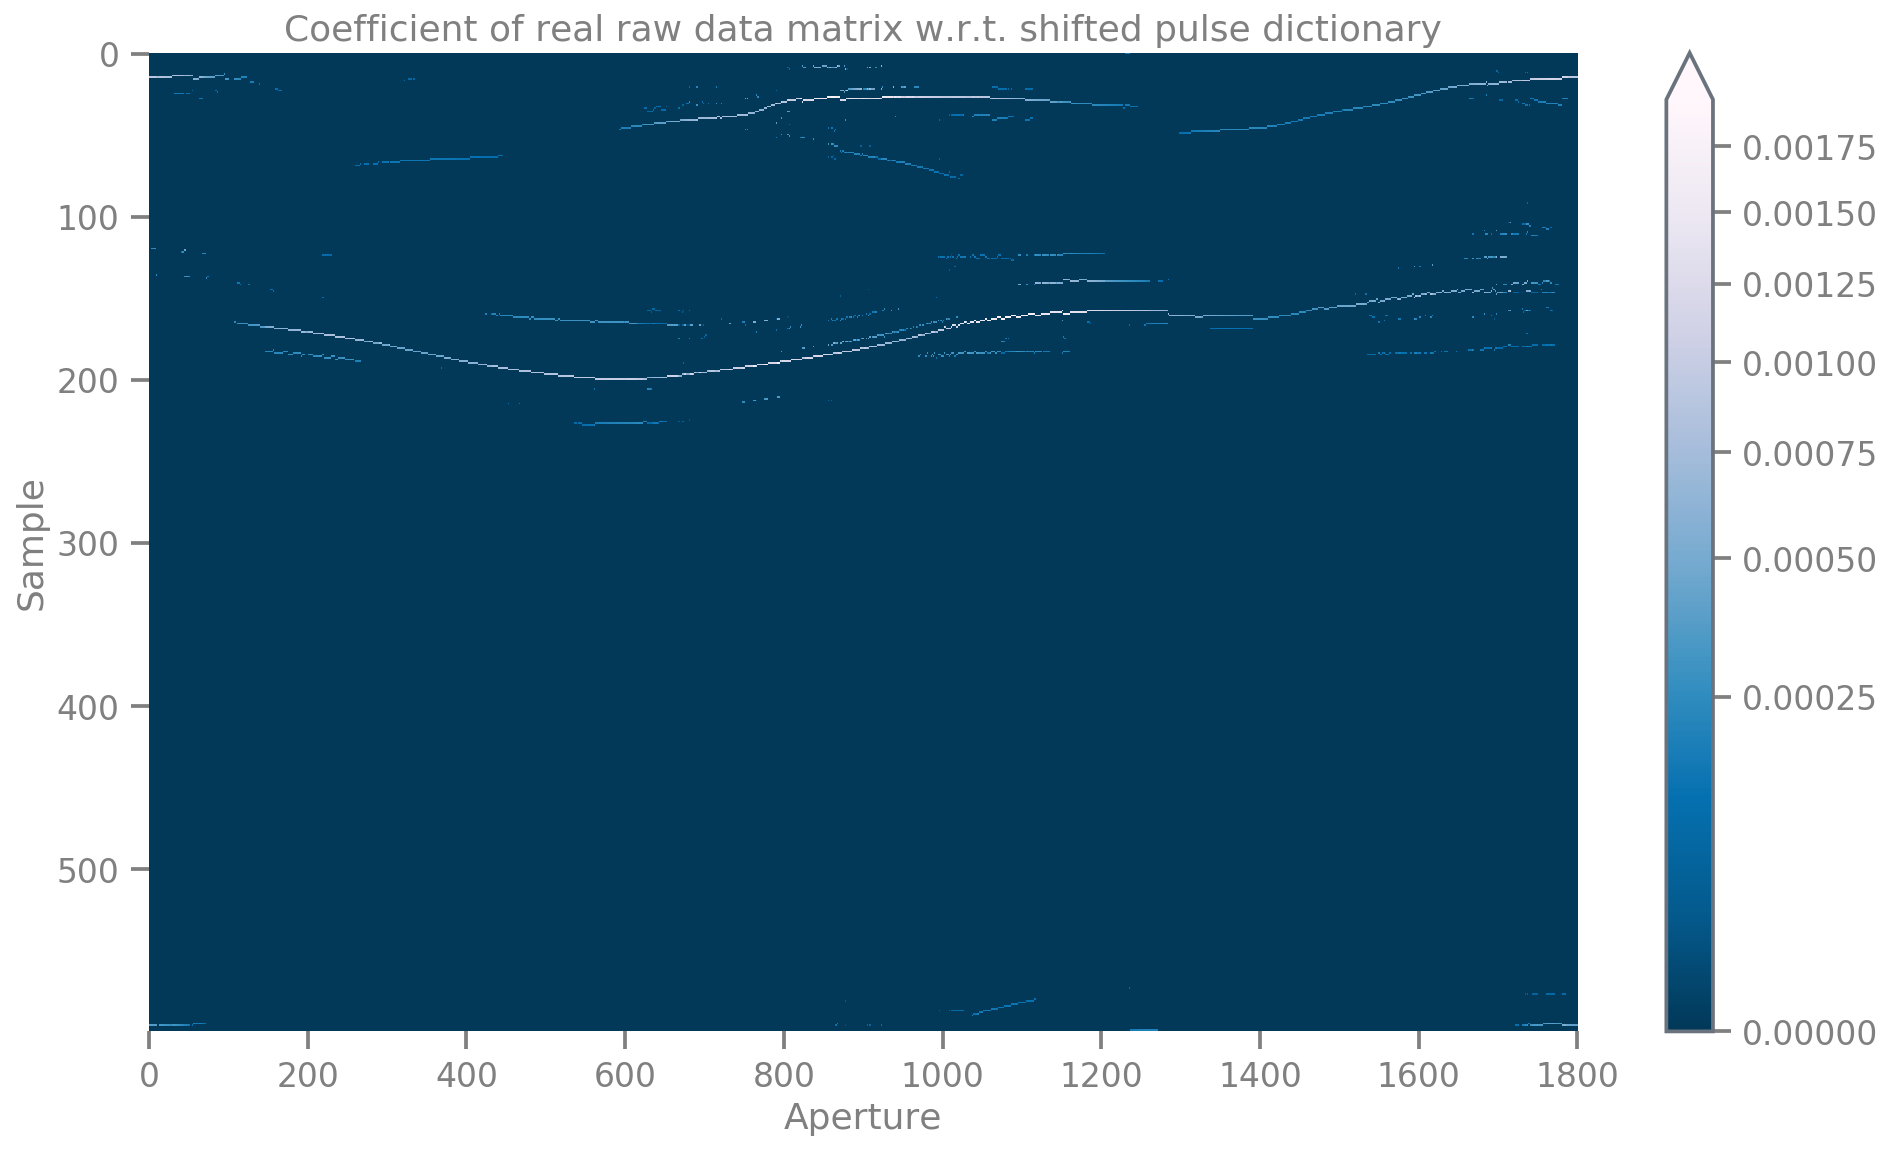

In [40]:
fig = plt.figure(figsize=(16, 9)); ax = fig.add_subplot(111)
pcm = ax.imshow(np.transpose(coef), aspect="auto", cmap="PuBu_r", 
            norm=PowerNorm(gamma=0.5))     
fig.colorbar(pcm, ax=ax, extend='max')
ax.set_title("Coefficient of real raw data matrix w.r.t. shifted pulse dictionary",
            color="gray")
ax.set_xlabel("Aperture"); ax.set_ylabel("Sample")
coef_matrix_filename_path = os.path.join(DATA_PATH, "figures", "playground", 
                                  real_data_filename+"_coef_matrix")
plt.savefig(coef_matrix_filename_path, dpi=300)

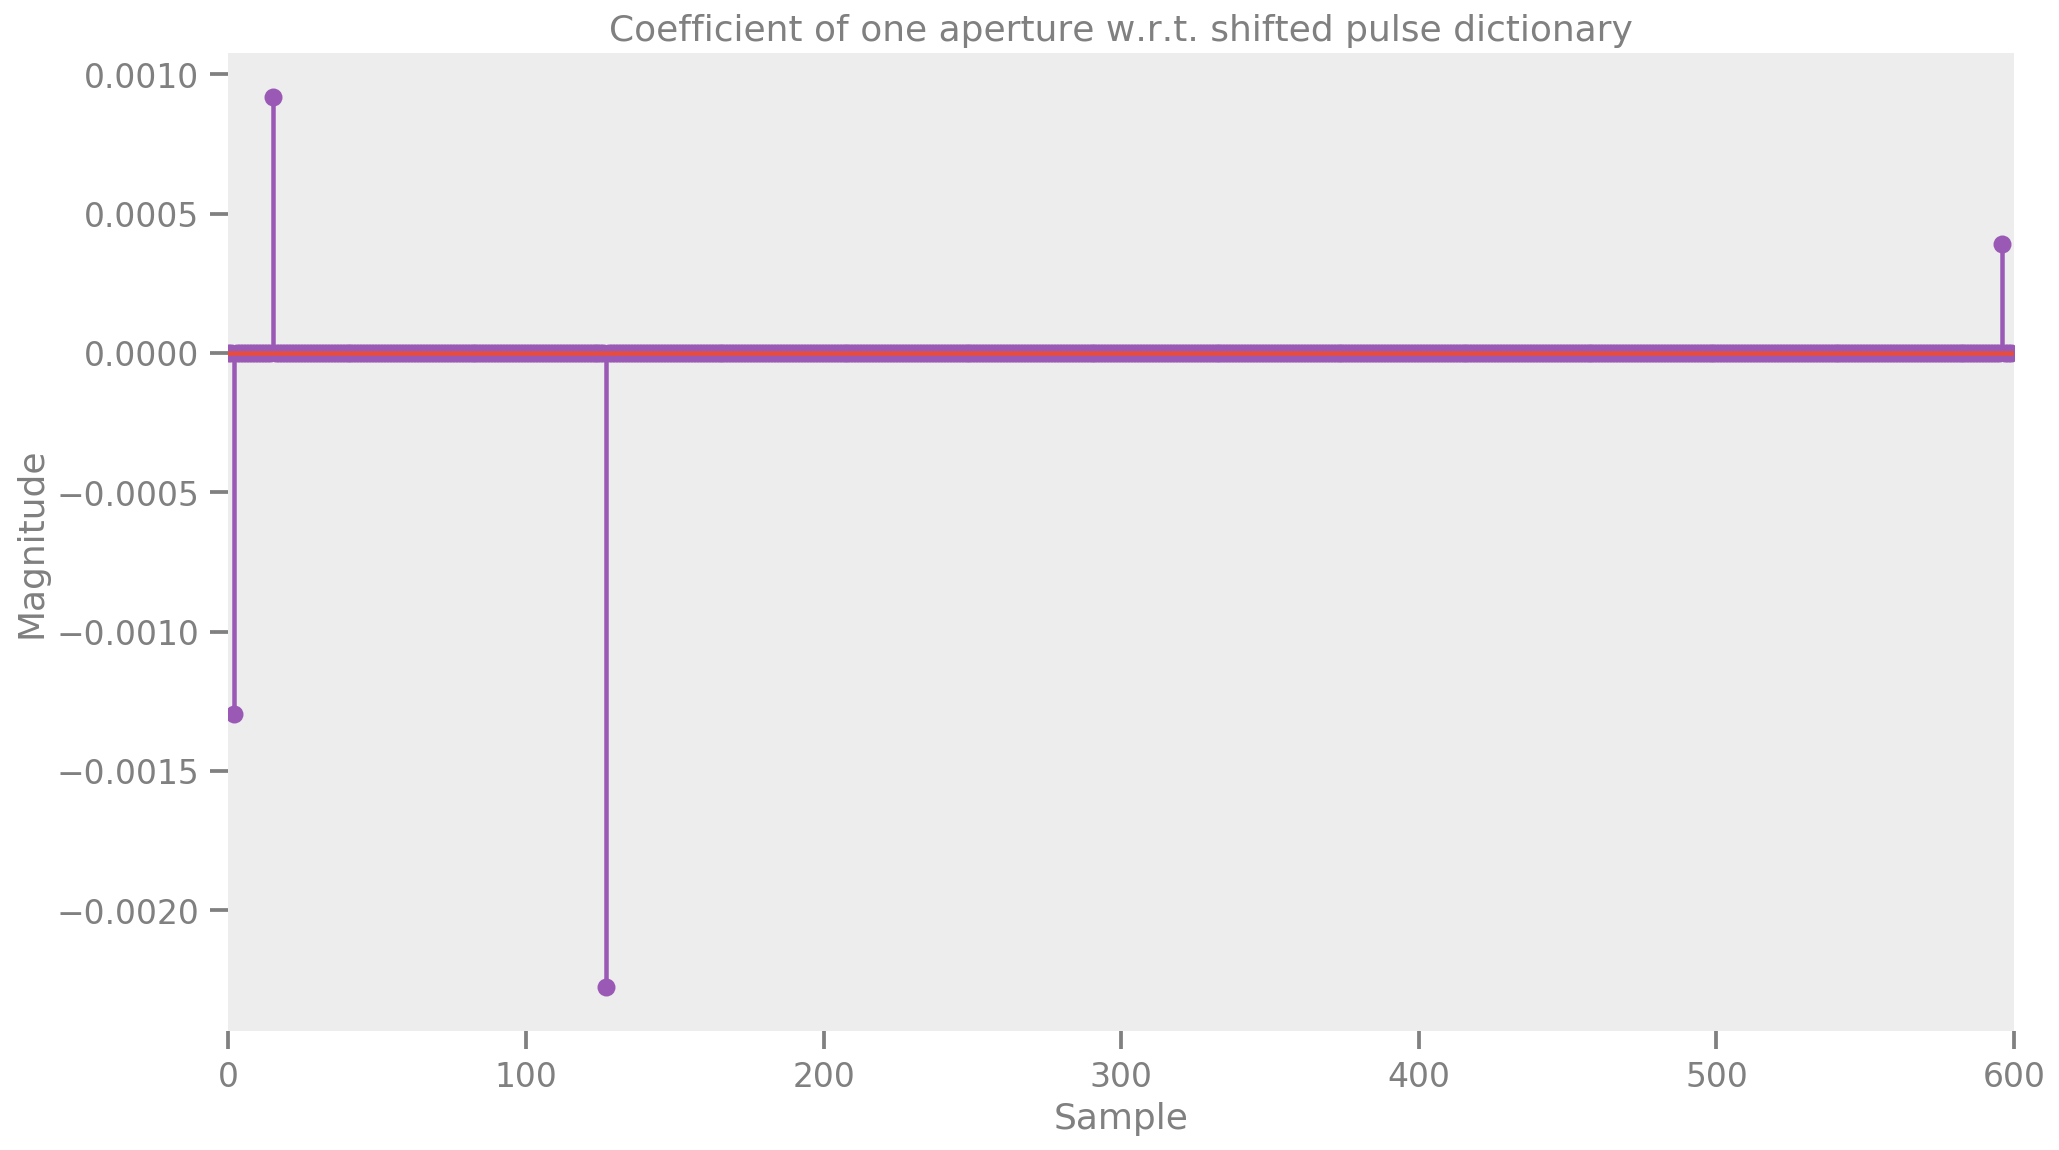

In [41]:
fig = plt.figure(figsize=(16, 9)); ax = fig.add_subplot(111)
ax.stem(coef[0, :])
ax.set_title("Coefficient of one aperture w.r.t. shifted pulse dictionary", 
            color="gray")
ax.set_xlabel("Sample"); ax.set_ylabel("Magnitude")
ax.set_xlim([0, coef.shape[1]])
coef_matrix_filename_path = os.path.join(DATA_PATH, "figures", "playground", 
                                  real_data_filename+"_coef_one_aperture")
plt.savefig(coef_matrix_filename_path, dpi=300)

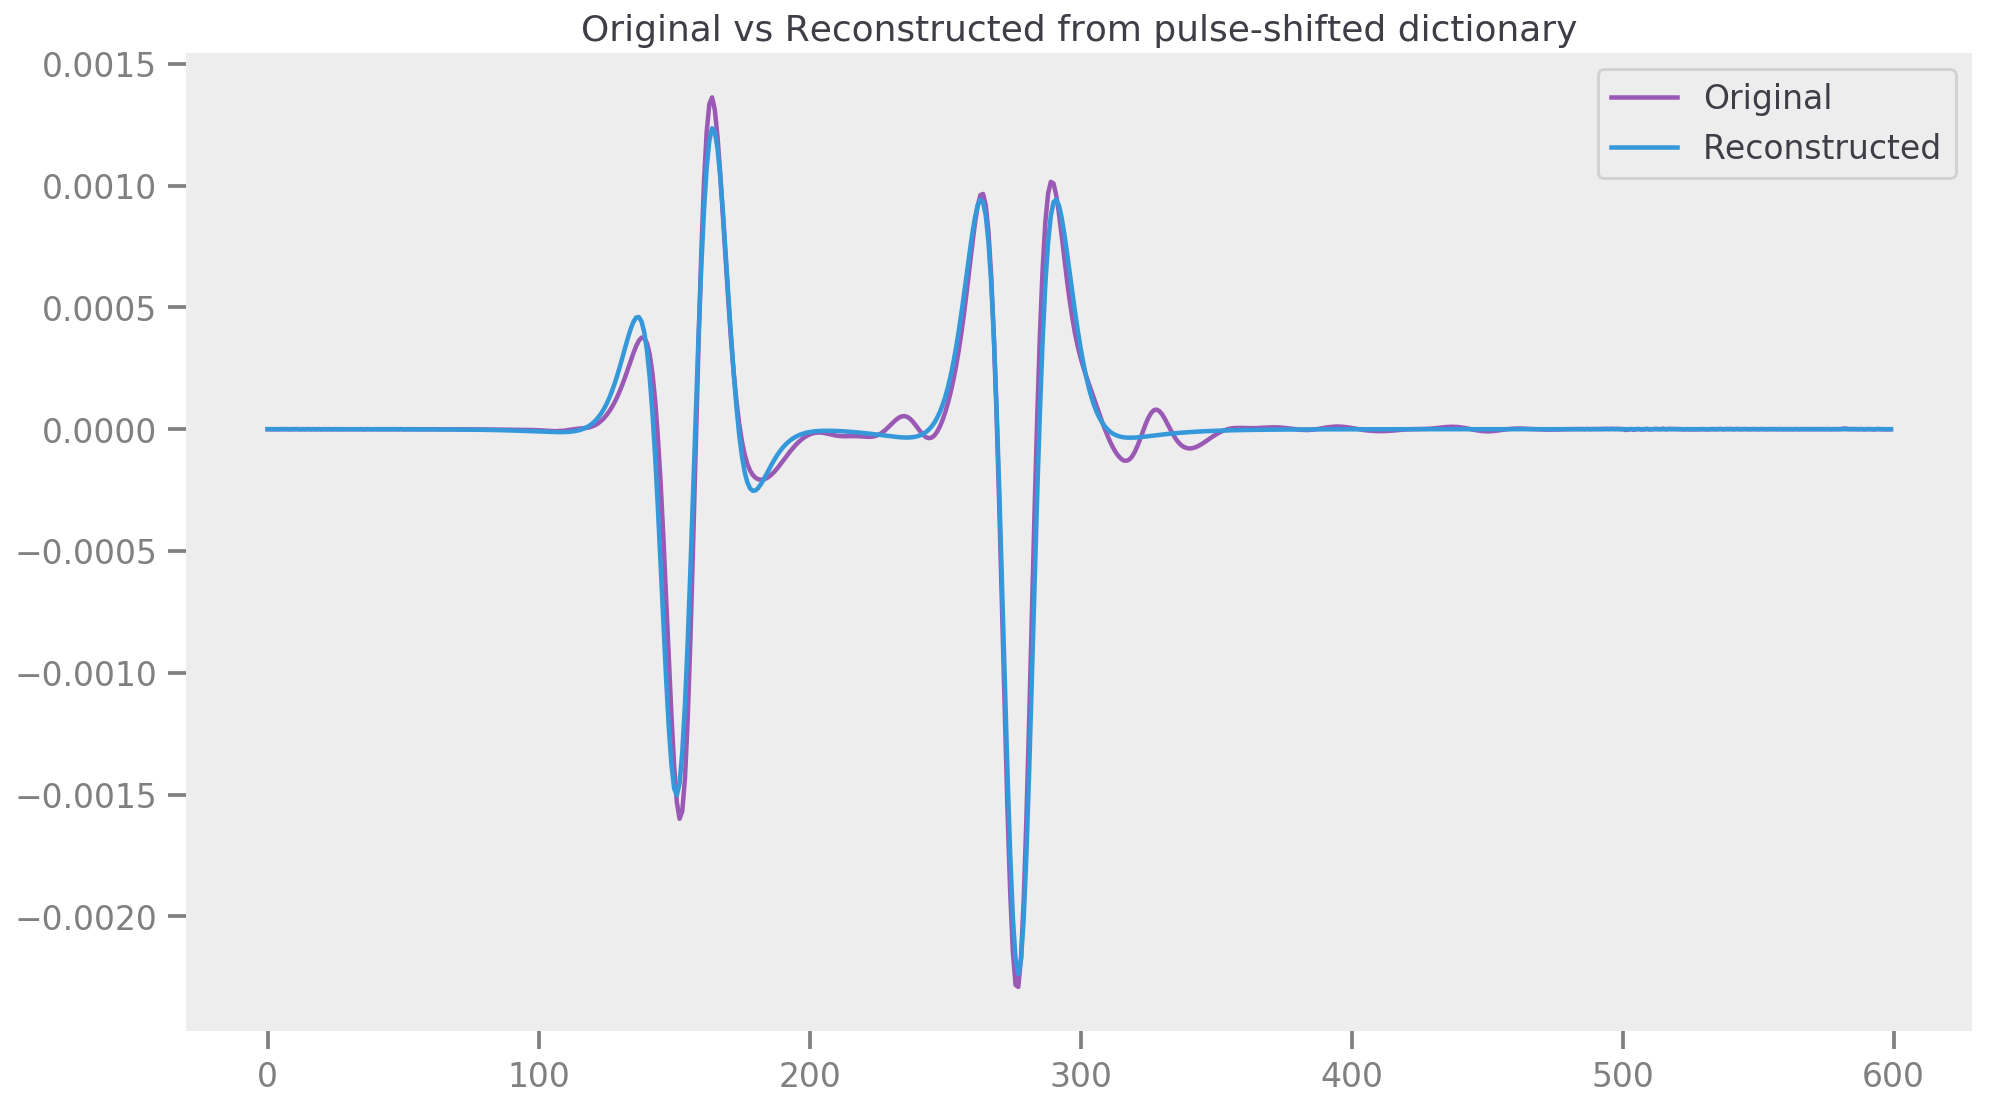

In [45]:
line_idx = 10
recontructed_column = np.dot(D, coef[line_idx, :])
fig = plt.figure(figsize=(16, 9)); ax = fig.add_subplot(111)
ax.plot(real_raw_data[:, line_idx], label="Original")
ax.plot(recontructed_column, label="Reconstructed")
ax.set_title("Original vs Reconstructed from pulse-shifted dictionary")
ax.legend()
np.linalg.norm(real_raw_data[:, line_idx] - recontructed_column)
reconstructed_from_dict_one_aperture_filename_path = os.path.join(DATA_PATH, "figures", "playground", 
                                  real_data_filename+"_reconstructed_from_dict_one_aperture")
plt.savefig(reconstructed_from_dict_one_aperture_filename_path, dpi=300)

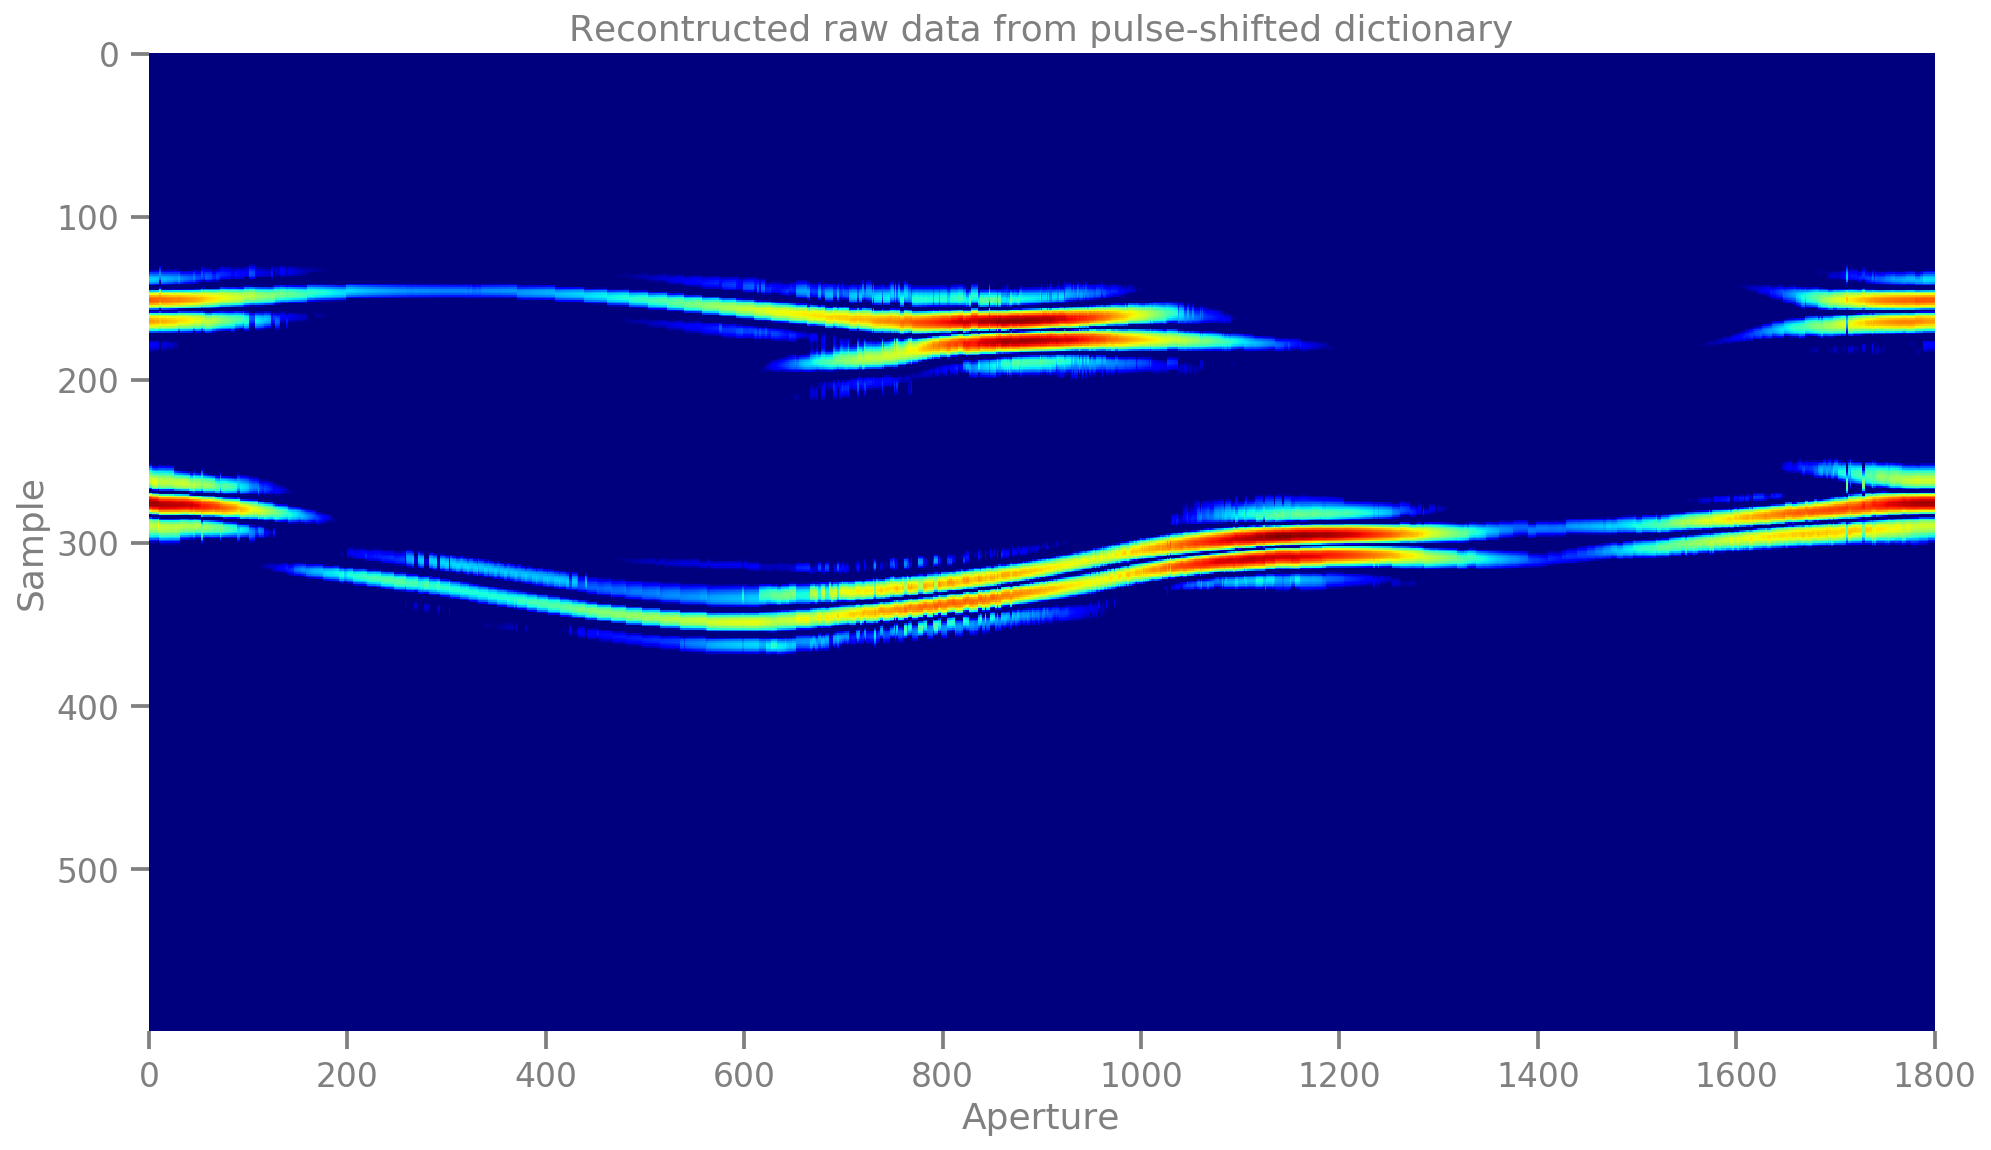

In [48]:
recontructed_raw_data = np.dot(D, np.transpose(coef))
fig = plt.figure(figsize=(16, 9)); ax = fig.add_subplot(111)
ax = visualize_raw_data(recontructed_raw_data, ax, set_ticks=True)
ax.set_title("Recontructed raw data from pulse-shifted dictionary", color="gray")
ax.set_xlabel("Aperture"); ax.set_ylabel("Sample")
recontructed_from_dict_raw_data_filepath = os.path.join(DATA_PATH, "figures", "playground", 
                                  real_data_filename+"_recontructed_from_dict_raw_data")
plt.savefig(recontructed_from_dict_raw_data_filepath, dpi=300)